# 📈 Step 4 – Predictive Modeling

This notebook includes:
- Logistic Regression
- XGBoost with class imbalance
- Confusion Matrix
- ROC Curve
- Feature Importance

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import class_weight

from xgboost import XGBClassifier

In [9]:
df = pd.read_csv('../data/processed/features_cleaned.csv')
X = df.drop(columns=['customer_id', 'churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [10]:
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Report")
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))

Logistic Regression Report
              precision    recall  f1-score   support

           0       0.74      0.48      0.58      1880
           1       0.23      0.48      0.31       620

    accuracy                           0.48      2500
   macro avg       0.49      0.48      0.45      2500
weighted avg       0.61      0.48      0.52      2500

ROC AUC: 0.4735338023335621


In [ ]:

from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weight = weights[0] / weights[1]

from xgboost import XGBClassifier
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print('ROC AUC:', roc_auc_score(y_test, y_prob_xgb))


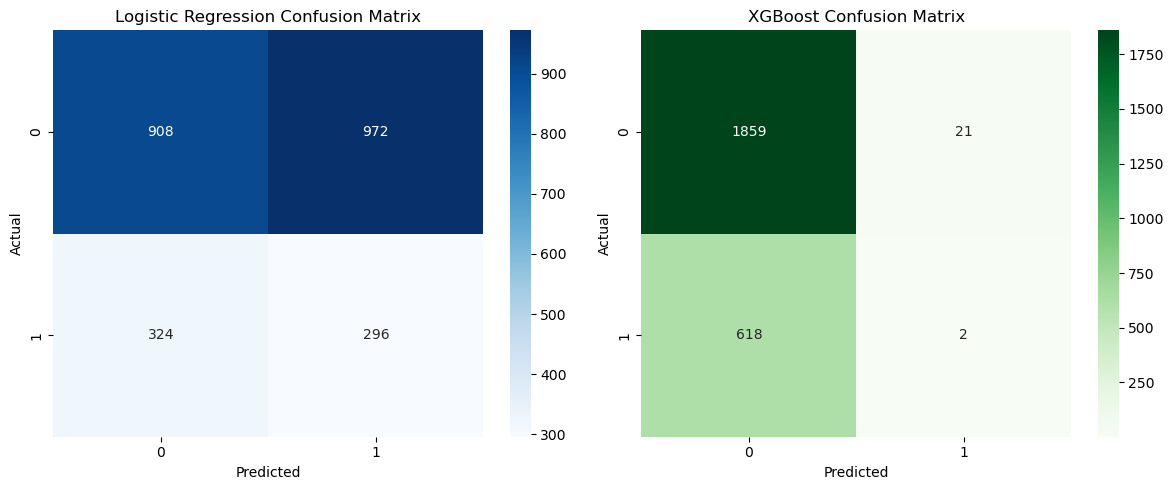

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', ax=axs[0], cmap='Blues')
axs[0].set_title('Logistic Regression Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', ax=axs[1], cmap='Greens')
axs[1].set_title('XGBoost Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

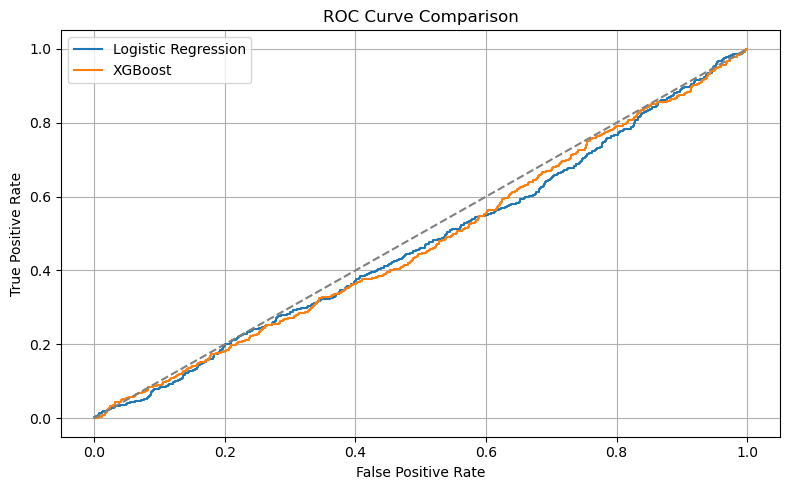

In [13]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 5))
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

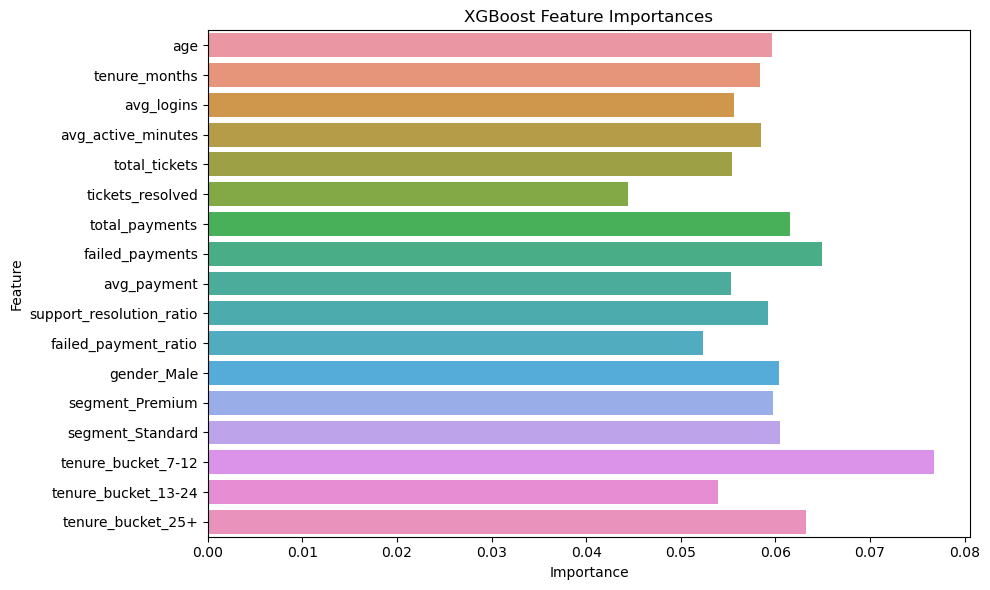

In [14]:
importances = xgb_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feat_names)
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 🔍 Model Performance Summary (Post Class Imbalance Handling)

### 🧪 Logistic Regression (`class_weight='balanced'`)

| Metric       | Value |
|--------------|-------|
| **Recall (Churn)**       | 0.48 ✅ |
| **Precision (Churn)**    | 0.23 ⚠️ |
| **F1-Score (Churn)**     | 0.31 |
| **ROC AUC**              | 0.47 ❌ |

- ✅ Model now detects churners (recall improved)
- ❌ Predicts churn too frequently → low precision
- ⚠️ Still underperforms overall — linear model may not capture complex churn signals

---

### 🌳 XGBoost (`scale_pos_weight` from training set)

| Metric       | Value |
|--------------|-------|
| **Recall (Churn)**       | 0.00 ❌ |
| **Precision (Churn)**    | 0.09 ❌ |
| **F1-Score (Churn)**     | 0.01 |
| **ROC AUC**              | 0.47 ❌ |

- ❌ XGBoost fails to identify churners at all
- ⚠️ Even with class weighting, model defaults to majority class
- Feature importance suggests weak signals — no single feature dominates

---

### 📊 Visual Insights

- **Confusion Matrices**: Both models heavily skewed toward predicting "No Churn"
- **ROC Curves**: Close to diagonal → No real separation between classes
- **Feature Importances**: Flat distribution → no strongly predictive features

---

### ✅ Recommendations

#### 🔄 Short-Term Improvements:
- Apply **SMOTE** or `RandomOverSampler` for churners
- Experiment with **threshold tuning** (e.g., predict churn if `prob > 0.3`)

#### 🧠 Strategic Next Steps:
- Proceed with **LSTM model** to capture sequential usage patterns
- Engineer more discriminative features (e.g., last-N-day dropoffs, trend shifts, downgrade indicators)

---
